In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import math
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


In [2]:
x_train = x_train.reshape(60000,28,28,1)
print(x_train[0].shape)

(28, 28, 1)


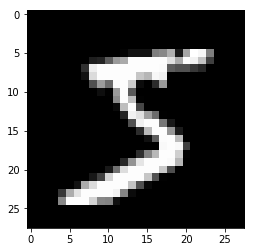

In [3]:
def one_hot(a,num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])
y_train = one_hot(y_train,10)
y_test = one_hot(y_test,10)
img = x_train[0]
img = np.array(img)
plt.imshow(img[:,:,0],cmap="gray")
plt.show()

In [4]:
def padding(arr,ker_rows,ker_cols,stride):
    row_pad_size = int(math.ceil((arr.shape[0]*(stride[0]-1)+ker_rows-stride[0])/2))  
    col_pad_size = int(math.ceil((arr.shape[1]*(stride[1]-1)+ker_rows-stride[1])/2))
    tmp1 = np.zeros((row_pad_size,arr.shape[1],arr.shape[2]))
    arr = np.vstack((tmp1,arr,tmp1))
    tmp2 = np.zeros((arr.shape[0],col_pad_size,arr.shape[2]))
    arr = np.hstack((tmp2,arr,tmp2))
    return arr

def conv_function(arr,ker,stride,activation):
    ker_rows = ker.shape[0]
    ker_cols = ker.shape[1]
    i=0
    j=0
    k=0
    l=0
    new_shape = (int((arr.shape[0]-ker_rows)/stride[0])+1,int((arr.shape[1]-ker_cols)/stride[1])+1,1)
    out = np.zeros(new_shape)
#     bias = np.random.normal(0,1,new_shape)
    while(1):
        if ker_rows+i > arr.shape[0]:
            break
        else:
            while(1):
                if ker_cols+j > arr.shape[1]: ### we reached the end of set corresponding to the current row
                    j=0
                    l=0
                    i=i+stride[0]
                    k=k+1
                    break
                else:
                    temp = arr[i:ker_rows+i,j:ker_cols+j,:]
                    out[k][l][0] = np.sum(temp*ker)
                    if activation == "relu":
                        out[k][l][0] = max(0,out[k][l][0])
                    j=j+stride[1]
                    l=l+1
    return out


# ### Q2 (The pooling function)

# In[5]:


def pool(arr,ker_shape,stride):
    ker_rows = ker_shape[0]
    ker_cols = ker_shape[1]
    i=0
    j=0
    k=0
    l=0
    mask = np.zeros(arr.shape)
    new_shape = (int((arr.shape[0]-ker_rows)/stride[0])+1,int((arr.shape[1]-ker_cols)/stride[1])+1)
    out = np.zeros(new_shape)
    while(1):
        if ker_rows+i > arr.shape[0]:
            break
        else:
            while(1):
                if ker_cols+j > arr.shape[1]: ### we reached the end of set corresponding to the current row
                    j=0
                    l=0
                    i=i+stride[0]
                    k=k+1
                    break
                else:
                    temp = arr[i:ker_rows+i,j:ker_cols+j]
                    temp1 = temp.reshape(-1,1)
                    temp2 = mask[i:ker_rows+i,j:ker_cols+j]
                    temp2 = temp2.reshape(-1,1)
                    temp2[np.argmax(temp1)] = 1
                    mask[i:ker_rows+i,j:ker_cols+j] = temp2.reshape((ker_rows,ker_cols))
                    out[k][l] = np.max(temp)
                    j=j+stride[1]
                    l=l+1
    return (out,mask)

def conv_volume(arr,kernel,stride,activation):
    depth  = kernel.shape[0]
    temp1  = []
    i=0
    while(i<depth):
        temp = conv_function(arr,kernel[i],stride,activation)
        temp1.append(temp)
        i=i+1
    temp1 = np.array(temp1)
    shape = temp1.shape
    temp1 = temp1.reshape(shape[0],shape[1],shape[2])
    output_volume = np.zeros((shape[1],shape[2],shape[0]))
    for i in range(depth):
        output_volume[:,:,i] = temp1[i,:,:]
    return output_volume

def pool_volume(arr,ker_shape,stride):
    depth = arr.shape[2]
    temp1 = []
    masks = []
    i=0
    while(i<depth):
        temp,mask = pool(arr[:,:,i],ker_shape,stride)
        temp1.append(temp)
        masks.append(mask)
        i=i+1
    temp1 = np.array(temp1)
    masks = np.array(masks)
    shape = temp1.shape
    shape1 = masks.shape
    temp1 = temp1.reshape(shape[0],shape[1],shape[2])
    masks = masks.reshape(shape1[0],shape1[1],shape1[2])
    output_volume = np.zeros((shape[1],shape[2],shape[0]))
    masks_volume = np.zeros((shape1[1],shape1[2],shape1[0]))
    for i in range(depth):
        output_volume[:,:,i] = temp1[i,:,:]
        masks_volume[:,:,i] = masks[i,:,:] 
    return (output_volume,masks_volume)


def unravel_fun(arr,weights):
    output = np.matmul(weights,arr)
    return output

def softmax(arr):
    arr = arr/np.max(arr)
    return np.exp(arr)/(np.sum(np.exp(arr),axis=0))

def fcn_layer(arr,weights,bias,num_nodes,activation):
    output = np.matmul(weights,arr) + bias
    if activation == "softmax":
        output = softmax(output)
    return output


In [5]:
def conv_backprop(arr,ker):
    ker_rows = ker.shape[0]
    ker_cols = ker.shape[1]
    ker = ker.reshape(ker_rows,ker_cols,1)
    i=0
    j=0
    k=0
    l=0
    new_shape = (int((arr.shape[0]-ker_rows))+1,int((arr.shape[1]-ker_cols))+1,arr.shape[2])
    out = np.zeros(new_shape)
    while(1):
        if ker_rows+i > arr.shape[0]:
            break
        else:
            while(1):
                if ker_cols+j > arr.shape[1]: ### we reached the end of set corresponding to the current row
                    j=0
                    l=0
                    i=i+1
                    k=k+1
                    break
                else:
                    temp = arr[i:ker_rows+i,j:ker_cols+j,:]
                    tmp = np.sum(temp*ker,axis=1)
                    out[k][l] = np.sum(tmp,axis=0)
                    j=j+1
                    l=l+1
    return out

def conv_backprop_volume(arr,kernel):
    depth  = kernel.shape[2]
    temp1  = []
    i=0
    while(i<depth):
        temp = conv_backprop(arr,kernel[:,:,i])
        temp1.append(temp)
        i=i+1
    temp1 = np.array(temp1)
    return temp1


In [13]:
### initialisations
W_conv1 = np.random.normal(0,1,(32,5,5,1))
W_conv2 = np.random.normal(0,1,(64,5,5,32))
W1 = np.random.uniform(0,1e-3,(1024,7*7*64))
W2 = np.random.uniform(0,1e-3,(10,1024))
b2 = np.random.uniform(0,1e-3,(10,1))

In [14]:
for i in range(30):
### forward pass
    padd_inp1 = padding(img,5,5,(1,1))
    conv_out1 = conv_volume(padd_inp1,W_conv1,(1,1),"relu")
    pool_out1,mask_inp1 = pool_volume(conv_out1,(2,2),(2,2))
    padd_inp2 = padding(pool_out1,5,5,(1,1))
    conv_out2 = conv_volume(padd_inp2,W_conv2,(1,1),"relu")
    pool_out2,mask_inp2 = pool_volume(conv_out2,(2,2),(2,2))
    x = pool_out2.reshape(-1,1)
    z = unravel_fun(x,W1)
    y = fcn_layer(z,W2,b2,10,"softmax")
    loss = -np.log(y[np.argmax(y_train[0])])
    print(loss)

    ### backprop starts here
    delta = y-y_train[0].reshape(-1,1)

    grad_W2 = np.matmul(delta,z.T)
    grad_b2 = delta

    s = np.matmul(W2.T,delta)
    grad_W1 = np.matmul(s,x.T)
    s1 = np.matmul(W1.T,s)
    s11 = s1.reshape((7,7,64))
    s11_rep = np.repeat(s11,2,axis=0)
    s11_rep = np.repeat(s11_rep,2,axis=1)
    s11_rep = s11_rep*mask_inp2
    labrat = conv_backprop_volume(padd_inp2,s11_rep)
    
    W_conv2 = W_conv2 - 0.0001*labrat
    W2 = W2 - 0.0001*grad_W2
    b2 = b2 - 0.0001*grad_b2
    W1 = W1 - 0.0001*grad_W1
    


[2.3088575]
[1.48568469]
[1.43865281]
[1.41977134]
[1.40933197]
[1.40258882]
[1.3978134]
[1.39422439]
[1.39141647]
[1.38915764]
[1.38730463]
[1.38576327]
[1.38446834]
[1.38337258]
[1.38244042]
[1.38164424]
[1.38096203]
[1.38037588]
[1.37987098]
[1.37943494]
[1.37905727]
[1.37872903]
[1.37844255]
[1.3781912]
[1.37796931]
[1.37777199]
[1.37759508]
[1.37743535]
[1.37729094]
[1.37716231]


In [8]:
lol = np.array([[[1,2],[3,4]],[[4,5],[6,7]]])
print(lol.shape)

(2, 2, 2)


In [9]:
tmp = np.sum(lol,axis=2)
tmp1 = np.sum(tmp,axis=1)
print(tmp1)

[10 22]
